# OpenCV와 KNN을 활용한 이미지 분류

이 노트북은 **OpenCV**를 이용한 **이미지 전처리(이진화, 외곽선 검출, 크기 정규화 등)**와, **KNN 알고리즘**을 결합하여 간단한 **숫자 이미지 분류** 예제를 구현합니다.

## 주요 내용
1. **이론** 보충 (KNN 개념, OpenCV 함수 설명)
2. **데이터 전처리** (digits.png 분할, 학습 데이터 준비)
3. **OpenCV**를 통한 추가 전처리 (이진화, 외곽선, 크기 조정)
4. **KNN 알고리즘** 구현 (OpenCV `cv2.ml.KNearest_create()`)
5. **테스트** (테스트 이미지 전처리 & 분류 결과 시각화)
6. **과제** (K 값 비교, 추가 전처리 기법, 결과 개선 등)

Colab 환경에서 GUI창을 띄우는 대신, `google.colab.patches` 모듈의 **`cv2_imshow`**를 사용합니다.

# 1. 환경 설정 및 라이브러리 불러오기

In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.10.0


# 2. KNN 알고리즘 이론 보충
**K-최근접 이웃(KNN)** 알고리즘은 분류(classification)나 회귀(regression)에 사용되는 **비지도 학습**(오해 주의: KNN은 지도학습) 기법 중 하나로,
테스트 데이터가 주어졌을 때 **가장 가까운 K개의 이웃**을 찾고, 그들의 레이블을 참고하여 새로운 데이터의 레이블을 결정합니다.

OpenCV에서는 `cv2.ml.KNearest_create()`를 통해 KNN 모델을 생성할 수 있으며,
 - `train()` 함수를 통해 학습 데이터를 입력,
 - `findNearest()` 함수를 통해 테스트 데이터를 분류할 수 있습니다.

```python
knn = cv2.ml.KNearest_create()
knn.train(trainData, cv2.ml.ROW_SAMPLE, trainLabels)
ret, result, neighbours, dist = knn.findNearest(sampleData, k)
```

- **trainData**: (N, D) 형태의 부동소수점 배열(N개의 샘플, 각 샘플 D차원)
- **trainLabels**: (N,1) 형태의 레이블(정수)
- `sampleData`: (1, D) 형태의 테스트 벡터
- **k**: 이웃 개수
- **result**: 예측 결과 레이블
- **neighbours**: 거리상 가장 가까운 K개 이웃의 레이블
- **dist**: 해당 이웃과의 거리


# 3. 데이터 전처리 및 학습 데이터 준비
OpenCV에서 제공하는 `digits.png`(5000개의 숫자 이미지가 하나의 큰 이미지로 배치)를 이용해 학습용 데이터를 구축합니다.
 - 숫자(0~9)가 500장씩, 총 5000장.
 - 각 숫자는 20×20 크기로 되어 있으며, 세로 50줄(0~9 반복 5회), 가로 100줄(각 줄에 0~9 반복 10회 × 10세트?).

전처리 과정
1. 이미지를 그레이스케일로 로드
2. 50×100으로 vsplit/hsplit 하여 20×20 셀 단위로 분할
3. 각 셀(20×20)을 1×400 벡터로 변환 -> 학습 데이터(`train`)
4. 레이블(`train_labels`) 생성 -> 0~9를 각각 500번 반복
5. `np.savez`로 저장


Original Image Shape: (1000, 2000)


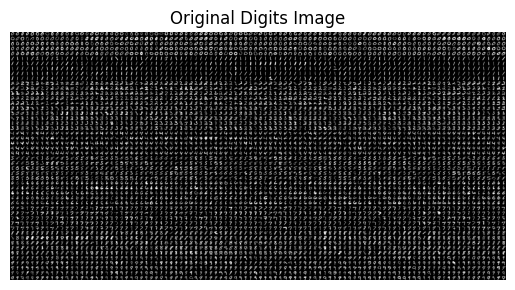

Training data saved as 'trained_opencv.npz'!


In [ ]:
# 3.1 digits.png 로드 (그레이스케일)
# wget으로 파일 다운로드
url = "https://raw.githubusercontent.com/npinto/opencv/master/samples/python2/data/digits.png"
output_file = "digits.png"
os.system(f"wget -O {output_file} {url}")

# OpenCV로 이미지 읽기
img_digits = cv2.imread(output_file, cv2.IMREAD_GRAYSCALE)
if img_digits is None:
    print("digits.png를 불러올 수 없습니다.")
else:
    print(f"Original Image Shape: {img_digits.shape}")
    plt.imshow(img_digits, cmap='gray')
    plt.title("Original Digits Image")
    plt.axis('off')
    plt.show()

    # 3.2 이미지 분할
    # 세로 50줄, 가로 100줄로
    cells = [np.hsplit(row, 100) for row in np.vsplit(img_digits, 50)]
    x = np.array(cells)  # shape (50, 100, 20, 20)

    # 각 셀(20x20)을 1x400 벡터로 변환
    train = x.reshape(-1, 400).astype(np.float32)  # (50*100, 400)

    # 레이블 생성 (0~9 각각 500번 = 5000)
    k = np.arange(10)
    train_labels = np.repeat(k, 500)[:, np.newaxis]

    # 데이터 저장
    np.savez("trained_opencv.npz", train=train, train_labels=train_labels)
    print("Training data saved as 'trained_opencv.npz'!")

# 4. 이미지 전처리 함수 (OpenCV 활용)
테스트 이미지(예: test_digit_3.png)가 주어졌을 때, 다음 작업을 수행하여 KNN에 입력할 벡터(1×400) 형태로 만들어 줍니다.
1. **이미지 불러오기**(그레이스케일)
2. **이진화**(Threshold)
3. **외곽선(contours) 검출**(시각적 확인)
4. **크기 조정**(20×20)
5. 1×400 형태로 reshape + float32 변환

Colab 환경에서는 `cv2.imshow` 대신 **`cv2_imshow`** 사용.

In [ ]:
def preprocess_image_colab(image_path):
    """
    테스트 이미지(예: 숫자 1장) 전처리:
    1) GRAYSCALE 로드
    2) 이진화
    3) 외곽선 표시 (시각화용)
    4) 20x20 크기로 리사이즈
    5) 1x400 형태로 벡터화 (float32)
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    # 이진화
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # 외곽선 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_with_contours, contours, -1, (0,255,0), 2)

    # 크기 조정(20x20)
    resized = cv2.resize(binary, (20, 20))

    # 시각화 (Colab)
    print("[Original Grayscale]")
    cv2_imshow(img)
    print("[Binary Inverted]")
    cv2_imshow(binary)
    print("[Contours Drawn]")
    cv2_imshow(img_with_contours)
    print("[Resized 20x20]")
    cv2_imshow(resized)

    # reshape(1, 400), float32
    vector_400 = resized.reshape(-1, 400).astype(np.float32)
    return vector_400

# 5. KNN 알고리즘 및 테스트
OpenCV의 `cv2.ml.KNearest_create()`를 통해 KNN 모델을 생성하고, `train()` → `findNearest()` 순으로 분류를 진행합니다.

```python
ret, result, neighbours, dist = knn.findNearest(sampleData, k)
```
- **result**: 예측된 레이블
- **neighbours**: 가까운 K개 이웃의 레이블
- **dist**: 각 이웃과의 거리

In [ ]:
def knn_train_and_test_colab(train_data, train_labels, test_image_path, k=3):
    # 1) KNN 모델 생성
    knn = cv2.ml.KNearest_create()

    # 2) 모델 학습
    # train_data.shape: (5000, 400), train_labels.shape: (5000,1)
    knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)

    # 3) 테스트 이미지 전처리
    test_vector = preprocess_image_colab(test_image_path)  # (1, 400)

    # 4) 예측
    ret, result, neighbours, dist = knn.findNearest(test_vector, k)
    predicted_label = int(result[0][0])

    print(f"Predicted Label: {predicted_label}")
    print(f"Neighbours: {neighbours}")
    print(f"Distances: {dist}")

    return predicted_label, neighbours, dist

### 5.1 학습 데이터 로드
앞서 `trained_opencv.npz` 파일에 저장된 학습 데이터를 로드하고, 테스트 이미지를 분류해봅시다.

In [ ]:
# 학습 데이터 로드
train_data = None
train_labels = None
try:
    with np.load('trained_opencv.npz') as data:
        train_data = data['train']
        train_labels = data['train_labels']
    print(f"train_data.shape = {train_data.shape}, train_labels.shape = {train_labels.shape}")
except FileNotFoundError:
    print("trained_opencv.npz 파일이 존재하지 않습니다. 앞 셀을 실행해주세요.")

train_data.shape = (5000, 400), train_labels.shape = (5000, 1)


### 5.2 테스트 실행

In [ ]:
# 테스트 이미지 (예: test_digit_3.png) - digits.png의 한 셀을 잘라 저장했다고 가정
test_image_path = 'test_digit_3.png'  # Colab 환경에 업로드된 테스트 이미지

pred_label, neighbours, distances = None, None, None
if train_data is not None and train_labels is not None:
    pred_label, neighbours, distances = knn_train_and_test_colab(
        train_data, train_labels, test_image_path, k=5
    )

[Original Grayscale]


[Binary Inverted]


[Contours Drawn]


[Resized 20x20]


Predicted Label: 3
Neighbours: [[3. 8. 3. 8. 5.]]
Distances: [[2558487. 2685142. 2689277. 2797677. 2855003.]]


# 6. 결과 시각화 (예측 결과 표시)
분류 결과를 **이미지 위**에 텍스트로 표시합니다. (Colab에서는 `cv2_imshow` 사용)

```python
cv2.putText(output, text, org, fontFace, fontScale, color, thickness)
```
- **org**: 텍스트 시작 위치 (x, y)
- **color**: BGR 색상
- **thickness**: 글자 테두리 두께


In [ ]:
def visualize_result_colab(image_path, predicted_label):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")

    output = img.copy()
    text = f"Predicted: {predicted_label}"
    cv2.putText(
        output, text, (10,50),
        cv2.FONT_HERSHEY_SIMPLEX, 1,
        (0,255,0), 2
    )

    print("[Test Image with Prediction]")
    cv2_imshow(output)

In [ ]:
# 결과 시각화
if pred_label is not None:
    visualize_result_colab(test_image_path, pred_label)

[Test Image with Prediction]


# 7. 과제
1. **K 값 비교**
   - k=1,3,5,7,9 등 다양한 값을 적용해 보고, 테스트 결과(정확도)를 비교하세요.
   - 여러 개의 테스트 이미지를 준비(예: 0~9 각각)해서, K에 따른 성능 차이를 분석해봅시다.

2. **전처리 개선**
   - 현재 이진화 임계값(128)으로 고정했는데, `cv2.THRESH_OTSU`나 `cv2.adaptiveThreshold` 등 다른 방식을 시도해 보세요.
   - 노이즈가 심한 이미지라면, 가우시안 블러 후 이진화 등 추가 전처리.

3. **다른 분류 알고리즘 시도**
   - SVM(`cv2.ml.SVM_create()`), RandomForest 등으로 확장해볼 수도 있습니다.

4. **ROI(Region of Interest) 탐색**
   - 하나의 큰 테스트 이미지가 있을 때, 여러 개의 숫자를 자동으로 잘라내 각각 분류해보세요.
   - 컨투어를 감싸는 boundingRect를 이용해 ROI를 추출한 뒤, 20×20 정규화.

5. **실행 시간 / 정확도 측정**
   - 테스트 이미지를 늘려가며, KNN의 속도와 정확도를 측정.
   - K가 커지면 정확도가 어떻게 변하는지, 시간이 얼마나 늘어나는지 비교.


## 7.1 과제 결과 예시 코드: K 값 루프
아래 예시는 K 값을 바꾸어가며 여러 테스트 이미지를 분류해 보고, 예측 결과를 단순히 출력만 합니다.
추가로 정확도를 계산하려면 실제 레이블과 비교가 필요합니다.

In [ ]:
def test_knn_with_different_k(train_data, train_labels, test_images, k_values=[1,3,5,7,9]):
    results = {}
    for k_ in k_values:
        print(f"\n=== K={k_} ===")
        knn = cv2.ml.KNearest_create()
        knn.train(train_data, cv2.ml.ROW_SAMPLE, train_labels)
        pred_labels = []
        for img_path, true_label in test_images:
            test_vec = preprocess_image_colab(img_path)
            ret, result, neigh, dist = knn.findNearest(test_vec, k_)
            plabel = int(result[0][0])
            pred_labels.append(plabel)
            print(f"Test Image={img_path}, True Label={true_label}, Predicted={plabel}")

        results[k_] = pred_labels
    return results

## 예시 사용
# 여러 테스트 이미지를 준비했다고 가정 (파일명, 실제 라벨)
test_imgs = [
    ("test_digit_0.png", 0),
    ("test_digit_3.png", 3),
    # ... 필요에 따라 추가
]

if train_data is not None and train_labels is not None:
    # k=1,3,5,7,9 등 루프
    _results = test_knn_with_different_k(train_data, train_labels, test_imgs, k_values=[1,3,5])
    print("\nKNN test done!")

# 8. 참고 자료
- [OpenCV 공식 문서](https://docs.opencv.org/4.x/)
  - ml 모듈 (KNN, SVM, etc.), 이미지 처리 함수(threshold, findContours, resize 등)
- [LearnOpenCV](https://learnopencv.com/)
  - 다양한 OpenCV 예제 및 딥러닝 응용.
- [KNN 알고리즘 개요 (Scikit-learn)](https://scikit-learn.org/stable/modules/neighbors.html)
  - KNN 분류/회귀 이론과 파라미터 설명.

본 예제는 기본적인 **숫자 이미지(KNN) 분류**를 목표로 하지만, 전처리를 개선하거나 다른 분류기를 적용해볼 수도 있습니다. 다양한 시도를 통해 **정확도**를 향상시켜 보세요!